# Matrix Factorization implementation 

Iván Vallés Pérez - 2018

In a [recommender system](https://en.wikipedia.org/wiki/Recommender_system) we have two kind of entities: users and items. We want to predict for an arbitrary user which items the user prefers. Sometimes users give explicit ratings, for example 4 or 5 star reviews. Let's start with this case and give an accurate mathematical formulation of the problem.

We will call $r_{ij}$ the rating that user $i$ gives to item $j$ and we want to build a model to predict these ratings. Let's call the predictions of the model $\hat{r}_{ij}$. It's important to realize that since each user will probably give ratings to just a handful of items and in most cases there are thousands or even millions of items we don't have ratings for the vast majority of user-item possible interactions. Let's call $I$ the set of known interactions and let's suppose that we want to minimize the squared loss, that is, we want to minimize:

\begin{equation}
L = \sum_{(i,j) \in I} (r_{ij} - \hat{r}_{ij})^2
\end{equation}

A matrix-factorization based recommender will solve the above problem by supposing that:

- We represent user $i$ with an unknown user bias $u_i^b$ and an unknown vector of length $K$ that we will call $u_i^e$, which is usually called the user embedding.
- We represent item $j$ with an unknown item bias $v_j^b$ and an unknown vector of length $K$ that we will call $v_j^e$, which is usually called the item embedding.
- The predicted rating of item $j$ by user $i$ is the biases plus the dot product of the two embeddings: 

\begin{equation}
\hat{r}_{ij} = u_i^b + v_j^b + u_i^e \cdot v_j^e = u_i^b + v_j^b + \sum_{k=1}^K u_{ik}^ev_{jk}^e
\end{equation}

The above vectors are the parameters of our problem and $K$ is a hyperparameter. If we have $N$ users and $M$ items this means that we have $(K + 1)(N + M)$ parameters. Substituting inside the loss function we have:

\begin{equation}
L = \sum_{(i,j) \in I} (r_{ij} - u_i^b - v_j^b - \sum_{k=1}^K  u_{ik}^ev_{jk}^e)^2
\end{equation}

To improve the generalization capabilities of the model regularization is added and finally we have:

\begin{equation}
L = \sum_{(i,j) \in I} (r_{ij} -  u_i^b - v_j^b - \sum_{k=1}^Ku_{ik}^ev_{jk}^e)^2 + \lambda_u\sum_{i,k} (u_{ik}^e)^2 + \lambda_v\sum_{j, k} (v_{jk}^e)^2
\end{equation}

$\lambda_u$ and $\lambda_v$ are two additional hyperparameters.

In [ ]:
%cd ..

In [2]:
from src.matrix_factorization import MatrixFactorization
from src.deep_factorization import DeepFactorization

C:\Users\Ivan Valles Perez\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Load the data and calculate the users set and items set cardinalities
df = pd.read_csv("./data/interactions.csv", names=["U", "I", "Q"])
U_cardinality = df.U.nunique()
I_cardinality = df.I.nunique()

In [4]:
# Generates and shuffles the data set to remove possible tendencies
np.random.seed(655321)
mat = df.values
np.random.shuffle(mat)

In [5]:
# Divide the data set into train-dev-test
train_mat = mat[:85000]
dev_mat = mat[85000:90000]
test_mat = mat[90000:]

In [6]:
# Separate features from target
x_train=(train_mat[:,:2]-1)
y_train=(train_mat[:,2:])
x_dev=(dev_mat[:,:2]-1)
y_dev=(dev_mat[:,2:])
x_test=(test_mat[:,:2]-1)
y_test=(test_mat[:,2:])

## Matrix Factorization

In [7]:
# Initialize the model and the performance accumulators for reporting purposes
# The metaparameters have been tuned to improve the algorithm performance
MF = MatrixFactorization(n_users=U_cardinality, n_items=I_cardinality, emb_size=5, lr=0.002, _lambda=0.1)
losses_train = [MF.evaluate(x_train, y_train, batch_size=1000)] # Add the initial loss (w. random weights)
losses_dev = [MF.evaluate(x_dev, y_dev, batch_size=1000)] # Add the initial loss (w. random weights)

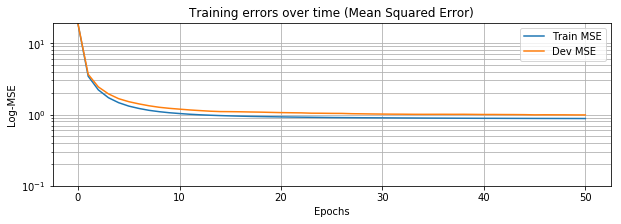

[EPOCH 50]   Train error = 0.8782 | Dev error = 0.9866
Test MSE achieved = 1.0151


In [8]:
for i in range(50): # Run for 50 epochs
    
    MF.fit(x_train, y_train, batch_size=128) # Compute an epoch using SGD
    losses_train.append(MF.evaluate(x_train, y_train, batch_size=128)) # Compute the train performance
    losses_dev.append(MF.evaluate(x_dev, y_dev, batch_size=128)) # Compute the dev. performance
    
    # Plot train and dev errors over time
    clear_output(True)
    plt.figure(figsize=[10, 3])
    plt.plot(losses_train)
    plt.plot(losses_dev)
    axes = plt.gca()
    plt.legend(["Train MSE", "Dev MSE"])
    plt.title("Training errors over time (Mean Squared Error)")
    plt.ylabel("Log-MSE")
    plt.xlabel("Epochs")
    plt.ylim([0.1, axes.get_ylim()[1]])
    plt.yscale('log')
    plt.grid(True, which="both",ls="-")
    plt.show()
    print("[EPOCH {0}]   Train error = {1:.4f} | Dev error = {2:.4f}".format(i+1, losses_train[-1], losses_dev[-1]))

print("Test MSE achieved = {0:.4f}".format(MF.evaluate(x_test, y_test, batch_size=128)))


## Extra: solution using deep learning

In [9]:
DF = DeepFactorization(n_users=U_cardinality, n_items=I_cardinality, emb_size=5, lr=0.002, _lambda=0.1)
losses_train = [DF.evaluate(x_train, y_train, batch_size=1000)] # Add the initial loss (w. random weights)
losses_dev = [DF.evaluate(x_dev, y_dev, batch_size=1000)] # Add the initial loss (w. random weights)

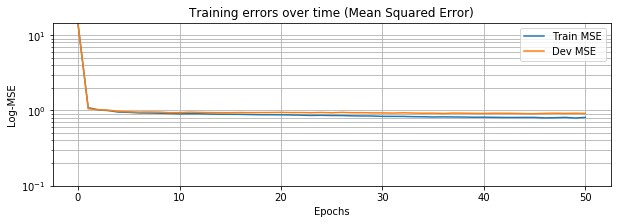

[EPOCH 50]   Train error = 0.8092 | Dev error = 0.9122
Test MSE achieved = 0.9285


In [10]:
for i in range(50): # Run for 50 epochs
    
    DF.fit(x_train, y_train, batch_size=128) # Compute an epoch using SGD
    losses_train.append(DF.evaluate(x_train, y_train, batch_size=128)) # Compute the train performance
    losses_dev.append(DF.evaluate(x_dev, y_dev, batch_size=128)) # Compute the dev. performance
    
    # Plot train and dev errors over time
    clear_output(True)
    plt.figure(figsize=[10, 3])
    plt.plot(losses_train)
    plt.plot(losses_dev)
    axes = plt.gca()
    plt.legend(["Train MSE", "Dev MSE"])
    plt.title("Training errors over time (Mean Squared Error)")
    plt.ylabel("Log-MSE")
    plt.xlabel("Epochs")
    plt.ylim([0.1, axes.get_ylim()[1]])
    plt.yscale('log')
    plt.grid(True, which="both",ls="-")
    plt.show()
    print("[EPOCH {0}]   Train error = {1:.4f} | Dev error = {2:.4f}".format(i+1, losses_train[-1], losses_dev[-1]))

print("Test MSE achieved = {0:.4f}".format(DF.evaluate(x_test, y_test, batch_size=128)))
